In [2]:
#packages
import pandas as pd
import pickle
import csv
import os
import re
import emoji
from textblob import TextBlob
import nltk
from langdetect import detect
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
import gensim
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse import coo_matrix, hstack
from scipy.sparse import csr_matrix
import sklearn
from scipy import spatial
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
import gensim.downloader
import fasttext

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luoyu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\luoyu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Sentence embedding 

In [3]:
#import sentiments prediction result from lstm
lstm_pred = pd.read_csv(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\lstm_pred\LSTM_prediction.csv")
lstm_pred = lstm_pred[lstm_pred['combined_tweet_txt'].notna()]
lstm_pred = lstm_pred.drop_duplicates(subset='combined_tweet_txt', keep="last")
list_of_txt = list(lstm_pred["combined_tweet_txt"])

In [4]:
#train word2vec with Gensim and import glove
tokens = [nltk.word_tokenize(sentences) for sentences in list_of_txt]
model = gensim.models.Word2Vec(tokens, min_count=1, size=25) 
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

glove_vectors = gensim.downloader.load('glove-twitter-25')
glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))
w2v.update(glove_vectors_w2v)

<ipython-input-4-64e7df3fd2bb>:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  w2v = dict(zip(model.wv.index2word, model.wv.syn0))
<ipython-input-4-64e7df3fd2bb>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))
<ipython-input-4-64e7df3fd2bb>:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))


In [29]:
# train word2vec with Fasttext
from gensim.models import FastText
FasTxt = FastText(list_of_txt, size=25)

In [ ]:
glove_vectors = gensim.downloader.load('glove-twitter-25')
glove_vectors_w2v = dict(zip(glove_vectors.wv.index2word, glove_vectors.wv.syn0))
FasTxt.update(glove_vectors_w2v)

In [5]:
#sentence embedding
def embedding(list_of_txt, model,size):
    Tfidf_model = TfidfVectorizer()
    Tfidf_model.fit(list_of_txt)
    tf_idf_dict = dict(zip(Tfidf_model.get_feature_names(), list(Tfidf_model.idf_)))
    documents = []
    for count,tweet in enumerate(list_of_txt):
    #word_vectors = []
        weight_sum = 0
        for word in tokens[count]: # or your logic for separating tokens
            sent_vec = np.zeros(size)
            if word in tf_idf_dict:
                tf_idf_score = tf_idf_dict[word]
                sent_vec += model[word]*tf_idf_score
                weight_sum += tf_idf_score
                #word_vectors.append(sent_vec)
        if weight_sum != 0:
            sent_vec /= weight_sum
        documents.append(sent_vec)
    return documents 
documents = embedding(list_of_txt,w2v,25)

In [6]:
##add word2vec vectors to lstm_pred column
lstm_pred['wordvec'] = documents
##filter the negative sentiment tweets
lstm_pred_negative = lstm_pred.copy().loc[lstm_pred['prediction'] == -1]
lstm_pred_negative['word_len'] = lstm_pred_negative['combined_tweet_txt'].str.len()
lstm_pred_negative.to_excel('lstm_pred_negative.xlsx')

In [17]:
#import manual labeled cluster samples from Bi Topic Modeling result and clean
cluster_sample = pd.read_excel(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\cluster_sample_txt.xlsx")
cluster_sample = cluster_sample.drop_duplicates(subset='combined_tweet_txt', keep="last")
cluster_sample = cluster_sample[cluster_sample['class'].notna()]
cluster_sample = cluster_sample[['class','combined_tweet_txt']]
#lstm_pred = lstm_pred.drop_duplicates(subset='combined_tweet_txt', keep="last")

##join with lstm_pred on combined text
cluster_joined = cluster_sample.set_index('combined_tweet_txt').join(lstm_pred.set_index('combined_tweet_txt'), how='left')
cluster_joined = cluster_joined.reset_index()


In [116]:
## test sentence embedding with cosine similarity 
##pick a sample tweet and calculate its similarity with the rest of the tweet in cluster_sample--BTM. Examine if the top ranked similar tweets are actually similar with the sample tweet
sample_text = lstm_pred_negative[lstm_pred_negative.combined_tweet_txt == 'volunteer ronavirus vaccine trial dies brazil via volunteer ronavirus vaccine trial dies brazil via']
sample_wordvec = list(sample_text['wordvec'])[0]
sample_text = sample_text['combined_tweet_txt']
#sample_text = list(cluster_joined['combined_tweet_txt'])[18]
columns_names = ['tweet_id','text_a','similarity','wordvec']
dict_sim = {}
for i, row in lstm_pred_negative.iterrows():
    result = 1 - spatial.distance.cosine(row.wordvec, sample_wordvec)
    if result < 1:
        dict_sim[row.combined_tweet_txt] = result

print(sample_text)
#rank similarity and show top n most similar tweets
similarity_df = pd.DataFrame.from_dict({k: v for k, v in sorted(dict_sim.items(), key=lambda item: item[1],reverse=True)},orient='index')
similarity_df.head(10)

C:\Users\luoyu\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


103854    volunteer ronavirus vaccine trial dies brazil ...
Name: combined_tweet_txt, dtype: object


,0
andrew cuomo americans skeptical ronavirus vaccine based players government nobody knowsandrew cuomo americans skeptical ronavirus vaccine based players government nobody knows trust via,1.0
who says 184 untries joined vax vaccine program via,1.0
vid 19 may never disappear even vaccine vallance says sent via vid 19 may never disappear even vaccine vallance says sent via,1.0
vid firm secures infect young volunteers hasten vaccine via,1.0
vid 19 may never disappear even vaccine vallance says sent via,1.0
usa plandemic ronavirus 5g vaccine deception full documentary via usa plandemic ronavirus 5g vaccine deception full documentary via,1.0
astrazeneca vid 19 vaccine trial volunteer died brazil health authority says arab news via,1.0
a paicipant astrazeneca clinical trial vaccine paicipant apparently get thea paicipant astrazeneca clinical trial vaccine paicipant apparently get vaccine local newspapers claim paicipant died vid 19 mplications via,1.0
a volunteer astrazeneca ronavirus vaccine trial died via,1.0
volunteer astrazeneca oxford vid 19 vaccine trial died brazil health authority says via,1.0


## Kmeans Cluster 

In [7]:
#import manual picked cluster center for initialization 
cluster_centers = pd.read_excel(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\cluster_center_txt.xlsx")
cluster_centers = cluster_centers[['class','combined_tweet_txt']]
#join cluster_centers with lstm_pred_negative to add word vectors
centers_joined = cluster_centers.set_index('combined_tweet_txt').join(lstm_pred_negative.set_index('combined_tweet_txt'), how='left')
centers_joined = centers_joined.reset_index()
centers = list(centers_joined['wordvec'])

#exclude short text (len<=50), preparation, short text cannot be used to manualy verify claster performance
lstm_pred_negative_long = lstm_pred_negative[lstm_pred_negative.word_len > 40]
X = list(lstm_pred_negative_long['wordvec'])

In [8]:
##run kmeans with selected centers for initialization
kmeans = KMeans(init = np.array(centers), n_clusters=6, random_state=5).fit(X)
predict =[i+1 for i in kmeans.labels_]
cluster_df = lstm_pred_negative_long.copy()
cluster_df['cluster'] = predict

#print cluster size
for n in range(6):
    print(n+1,len([i for i in predict if i == n+1]))

1 3899
2 2989
3 1596
4 1486
5 4541
6 490


<ipython-input-8-86cba8520f61>:2: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  kmeans = KMeans(init = np.array(centers), n_clusters=6, random_state=5).fit(X)


In [5]:
#load all dictionary to add precleaned txt, prepare for manual verification of cluster result
def read_json_to_dataframe(filename):
    print(filename)
    #f = open(filename,encoding = 'utf-16').read()
    f1 = pd.read_json(filename, orient='records',lines=True,encoding = 'utf-16')
    return f1
def read_in(path):
    files = os.listdir(path)
    all_dfs = []
    print(files)
    for i in files:
        if 'json' in i:
            each_df = read_json_to_dataframe(path+i)
            all_dfs.append(each_df)
            
    return pd.concat(all_dfs, ignore_index=True)

all_df = read_in('C:/Users/luoyu/Desktop/USCISI/vaccine hesitancy/raw/')
all_df = all_df[['og_tweet_txt','tweet_txt','tweet_id']]

['10-19-2020.json', '10-20-2020.json', '10-21-2020.json', '10-22-2020.json', '10-23-2020.json', '10-24-2020.json', '10-25-2020.json']
C:/Users/luoyu/Desktop/USCISI/vaccine hesitancy/raw/10-19-2020.json
C:/Users/luoyu/Desktop/USCISI/vaccine hesitancy/raw/10-20-2020.json
C:/Users/luoyu/Desktop/USCISI/vaccine hesitancy/raw/10-21-2020.json
C:/Users/luoyu/Desktop/USCISI/vaccine hesitancy/raw/10-22-2020.json
C:/Users/luoyu/Desktop/USCISI/vaccine hesitancy/raw/10-23-2020.json
C:/Users/luoyu/Desktop/USCISI/vaccine hesitancy/raw/10-24-2020.json
C:/Users/luoyu/Desktop/USCISI/vaccine hesitancy/raw/10-25-2020.json


In [10]:
sample = lstm_pred.sample(100)
sample = sample.set_index('tweet_id').join(all_df.set_index('tweet_id'), how='left')
lstm_pred_negative = lstm_pred.copy().loc[lstm_pred['prediction'] == -1]
negative_sample = lstm_pred_negative.sample(100)
negative_sample = negative_sample.set_index('tweet_id').join(all_df.set_index('tweet_id'), how='left')
sample.to_excel('./sentiment_test_sample.xlsx')
negative_sample.to_excel('./sentiment_test_negative_sample.xlsx')

In [20]:
#join cluster_df with all_df for cluster pre-cleand text
cluster_df = cluster_df.set_index('tweet_id').join(all_df.set_index('tweet_id'), how='left')
cluster_df = cluster_df.reset_index()[['tweet_id','combined_tweet_txt','cluster','og_tweet_txt','tweet_txt']]
#save cluster result to excel for manul verification
cluster_df_sample = cluster_df.groupby('cluster').apply(lambda x: x.sample(100))
cluster_df_sample.to_excel('cluster_df_sample_6x100_2.xlsx')

In [38]:
for i in list(all_df['tweet_id']):
    if '1318287612638072832' in str(i):
        print(i)

1318287612638072832


In [26]:
cluster_df

,tweet_id,combined_tweet_txt,cluster,og_tweet_txt,tweet_txt
0,1318287612638072832,it never fails amaze stupid proclaimed clever ...,2,,It never fails to amaze me how stupid some pro...
1,1318287821162119169,that insane paisan talk americans even politic...,1,,That is insane partisan talk and all American...
2,1318287901315256323,jim due respect take vaccine virus better 99,4,,"@JrLaslett @EmeraldRobinson Jim, with all due ..."
3,1318288044349423616,struggling get flu vaccine never mind one vid,6,,@guardian We’re struggling to get the flu vacc...
4,1318288127849627648,it appears 14 year old girl may developed vacc...,2,,It appears that a 14 year old girl may have de...
...,...,...,...,...,...
14996,1320268486753411073,vid 19 vaccine provokes like phase 3 trial vac...,6,Moderna’s COVID-19 Vaccine Provokes ‘COVID-Lik...,RT @NVICLoeDown: Moderna’s COVID-19 Vaccine Pr...
14997,1320268788139393024,ronavirus vaccine update launches ronil drug c...,6,Coronavirus vaccine update: #Patanjali launche...,RT @bsindia: Coronavirus vaccine update: #Pata...
14998,1320268842287837185,i vid trial paicipant please nsider joining study,2,,"I am a Covid trial participant, please consi..."
14999,1320268883056623616,major vaccine mpany whistleblower says new rna...,6,Major vaccine company WHISTLEBLOWER says the n...,RT @LotusOak2: Major vaccine company WHISTLEBL...


In [15]:
cluster_joined.drop_duplicates(subset='class', keep="first")
cluster_joined['kmean_predict'] = kmeans.predict(list(cluster_joined['wordvec']))
cluster_joined[['combined_tweet_txt','class','kmean_predict']]

,combined_tweet_txt,class,kmean_predict
0,elon musk take vid vaccine calls bill gates ne...,1.0,5
1,drink ol aid take vaccine cuomo fda thinks ame...,1.0,2
2,dictator newsom california denying freedom cho...,1.0,5
3,dictator newsom california denying freedom cho...,1.0,5
4,arrow uk elon musk take vid vaccine calls bill...,1.0,5
5,k ronavirus probably never disappear vaccine s...,2.0,5
6,everyone please retweet asymptomatic carriers ...,4.0,5
7,from flu ye came unto flu ye shall return rona...,2.0,5
8,a vid 19 vaccine unlikely fully stop spread vi...,2.0,5
9,it woh reflecting one human disease truly erad...,2.0,4


In [16]:
##load manually varified labeled claster result, and calculate accuracy,recall,precision,f1. stats table in cluster_sample_ana
cluster_df_sample_6x100 = pd.read_excel(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\cluster_df_sample_6x100.xlsx")
cluster_sample_ana= pd.DataFrame()
cluster_sample_ana['clusters']= [1,2,3,4,5,6]
cluster_sample_ana['cluster_names'] = ['Negative influence','Efficacy of the vaccines','Negative vaccine trial news','Distrust toward government and vaccine  research','Blatantly refuse',' Covid-19 is common flu']
accuracy,precision,recall,f1 = [],[],[],[]
tpl,fpl,fnl,tnl = [],[],[],[]
true_number = []

for i in range(6):
    single_cluster = cluster_df_sample_6x100[cluster_df_sample_6x100.cluster == i+1]
    single_class = cluster_df_sample_6x100[cluster_df_sample_6x100.true_class == i+1]
    true_number.append(len(single_class))
    tp = sum([1 for n,m in zip(list(single_cluster.cluster),list(single_cluster.true_class)) if n==m])
    fp = 100-tp
    fn = len(single_class)-tp
    tn = 500 - fn
    
    tpl.append(tp)
    fnl.append(fn)
    fpl.append(fp)
    tnl.append(tn)
    testy = [1 for n in list(single_cluster.cluster)]
    yhat_classes = [1 if n==i+1 else 0 for n in list(single_cluster.true_class)]
    accuracy.append((tp + tn) / 600)
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    f1.append(2*tp/(2*tp+fp+fn))
    #accracy.append(tp/100)

cluster_sample_ana['true_number'] = true_number
cluster_sample_ana['accuracy'] = accuracy
cluster_sample_ana['recall'] = recall
cluster_sample_ana['precision'] = precision
cluster_sample_ana['f1'] = f1
cluster_sample_ana['tp'] = tpl
cluster_sample_ana['fn'] = fnl
cluster_sample_ana['fp'] = fpl
cluster_sample_ana['tn'] = tnl

In [394]:
cluster_sample_ana

,clusters,cluster_names,true_number,accuracy,recall,precision,f1,tp,fn,fp,tn
0,1,Negative influence,42,0.803333,0.285714,0.12,0.169014,12,30,88,470
1,2,Efficacy of the vaccines,76,0.736667,0.118421,0.09,0.102273,9,67,91,433
2,3,Negative vaccine trial news,145,0.668333,0.158621,0.23,0.187755,23,122,77,378
3,4,Distrust toward government and vaccine research,81,0.751667,0.197531,0.16,0.176796,16,65,84,435
4,5,Blatantly refuse,12,0.820000,0.166667,0.02,0.035714,2,10,98,490
5,6,Covid-19 is common flu,16,0.820000,0.250000,0.04,0.068966,4,12,96,488


# binary classification

In [60]:
#biclass classification
def train_model(classifier, feature_vector_train, label, feature_vector_valid,valid_y,thresh):
    classifier.fit(feature_vector_train, label)
    predicted_proba = classifier.predict_proba(feature_vector_valid)
    predictions = (predicted_proba [:,1] >= thresh).astype('int')
    
    labels = np.unique(label)

    report = classification_report(valid_y,predictions,labels = labels,output_dict =True)
    
    return report

def train_classifier(X_train, y_train, X_valid,valid_y,thresh):
    report_list=[]
    for classifier, flag in zip(test_classifiers, test_classifiers_flag):
        report=train_model(classifier, X_train, y_train, X_valid,valid_y,thresh)
        #print('------------------The report of',flag,'--------------------')
        #print(report)
        #print(conf)
        report_list.append((flag,report))
    return report_list

def StratifiedSampling(df, test_size):
    X = df.drop(['y'], axis=1)
    y = df.y
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)    
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
    return train,test

def splitandtrain(df,thresh):
    train,test = StratifiedSampling(df, 0.5)
    train_x = list(train.wordvec)
    train_y = list(train.y)
    valid_x = list(test.wordvec)
    valid_y = list(test.y)
    report_list = train_classifier(train_x, train_y, valid_x,valid_y,thresh)
    return report_list

#get average classification stats by running split and train for 10 times. 
####cluster_df_1: a dataset df including training and testing
####thresh: probability threshold
def ave_score(cluster_df_1, thresh):
    for i in range(10):
        flag = test_classifiers_flag[0]
        report = splitandtrain(cluster_df_1[['y','wordvec']],thresh)[0]
        precision_list.append(report[1]['1']['precision'])
        recall_list.append(report[1]['1']['recall'])
        f1_list.append(report[1]['1']['f1-score'])
        accuracy_list.append(report[1]['accuracy'])
    print('-----------------',thresh,'-------------------')
    print('precision:', sum(precision_list)/len(precision_list))
    print('recall:', sum(recall_list)/len(recall_list))
    print('f1:', sum(f1_list)/len(f1_list))
    print('accuracy:', sum(accuracy_list)/len(accuracy_list))
    return sum(precision_list)/len(precision_list)

In [12]:
#classification methods
RF = RandomForestClassifier()
LR = LogisticRegressionCV(cv=5, random_state=0,max_iter=1000)
test_classifiers = [RF,LR]
test_classifiers_flag = ['RF','LR']

In [120]:
#pick the class for binary classification and prepare training data
bilabel = [1 if i==3 else 0 for i in list(cluster_df_sample_6x100.true_class)]
selected_class_num = sum(bilabel)
for_join = cluster_df_sample_6x100[['combined_tweet_txt']]
cluster_df_1 = for_join.set_index('combined_tweet_txt').join(lstm_pred_negative.set_index('combined_tweet_txt'), how='left')
cluster_df_1['y'] = bilabel
selected_class_tweets = cluster_df_1[cluster_df_1.y == 1]
other_class_tweets = cluster_df_1[cluster_df_1.y == 0]
cluster_df_1 = selected_class_tweets.append(other_class_tweets.sample(selected_class_num))
#RF_report,LR_report = splitandtrain(cluster_df_1[['y','wordvec']],0.5)

----------------- 0.30000000000000004 -------------------
precision: 0.4780811265109791
recall: 0.8486111111111111
f1: 0.6115575780600402
accuracy: 0.46482758620689657
0.4780811265109791
----------------- 0.4 -------------------
precision: 0.4940050912340362
recall: 0.8034722222222224
f1: 0.6106540068638461
accuracy: 0.49137931034482757
0.4940050912340362
----------------- 0.5 -------------------
precision: 0.5206590550377658
recall: 0.7319444444444445
f1: 0.6006445330227131
accuracy: 0.5202298850574713
0.5206590550377658
----------------- 0.6000000000000001 -------------------
precision: 0.5768116761114345
recall: 0.6416666666666667
f1: 0.5740936906907382
accuracy: 0.546206896551724
0.5768116761114345
----------------- 0.7000000000000001 -------------------
precision: 0.6314145111677854
recall: 0.5558333333333332
f1: 0.5272386181005256
accuracy: 0.5550344827586206
0.6314145111677854
----------------- 0.8 -------------------
precision: 0.6759795603572887
recall: 0.48402777777777767
f1:

Text(0, 0.5, 'precision')

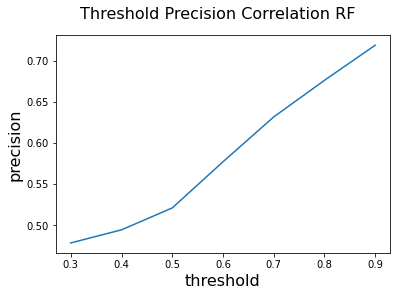

In [123]:
#plot Threshold Precision Correlation
test_classifiers = [RF]
test_classifiers_flag = ['RF']
precision_list, recall_list, f1_list, accuracy_list = [],[],[],[]
precision_line,thresh_line = [],[]

#find threshold correlation with precision
for j in range(7):
    thresh = 0.1*(j+3)
    thresh_line.append(thresh)
    precision = ave_score(cluster_df_1, thresh)
    precision_line.append(precision)
    print(precision)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(thresh_line,precision_line)
fig.suptitle('Threshold Precision Correlation '+test_classifiers_flag[0], fontsize=16)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('precision', fontsize=16)

# Active learning

In [160]:
#biclass classification for active learning
def train_model(classifier, feature_vector_train, label, feature_vector_valid,valid_y,thresh):
    classifier.fit(feature_vector_train, label)
    predicted_proba = classifier.predict_proba(feature_vector_valid)
    predictions = (predicted_proba [:,1] >= thresh).astype('int')
    
    labels = np.unique(label)

    report = classification_report(valid_y,predictions,labels = labels,output_dict =True)
    
    return report,classifier

def train_classifier(X_train, y_train, X_valid,valid_y,thresh):
    report_list=[]
    for classifier, flag in zip(test_classifiers, test_classifiers_flag):
        report,classifier=train_model(classifier, X_train, y_train, X_valid,valid_y,thresh)
        #print('------------------The report of',flag,'--------------------')
        #print(report)
        #print(conf)
        report_list.append((flag,report))
    return report_list,classifier

def StratifiedSampling(df, test_size):
    X = df.drop(['y'], axis=1)
    y = df.y
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)    
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
    return train,test

def splitandtrain(df,thresh):
    train,test = StratifiedSampling(df, 0.5)
    train_x = list(train.wordvec)
    train_y = list(train.y)
    valid_x = list(test.wordvec)
    valid_y = list(test.y)
    report_list,classifier = train_classifier(train_x, train_y, valid_x,valid_y,thresh)
    return report_list,classifier

def ave_score(cluster_df_1, thresh):
    for i in range(10):
        flag = test_classifiers_flag[0]
        report, classifier = splitandtrain(cluster_df_1[['y','wordvec']],thresh)
        report = report[0]
        #print(report)
        precision_list.append(report[1]['1']['precision'])
        recall_list.append(report[1]['1']['recall'])
        f1_list.append(report[1]['1']['f1-score'])
        accuracy_list.append(report[1]['accuracy'])
    #print(thresh)
    #print('precision:', sum(precision_list)/len(precision_list))
    #print('recall:', sum(recall_list)/len(recall_list))
    #print('f1:', sum(f1_list)/len(f1_list))
    #print('accuracy:', sum(accuracy_list)/len(accuracy_list))
    return sum(precision_list)/len(precision_list)

In [203]:
#pick the class for binary classification and prepare training data
bilabel = [1 if i==3 else 0 for i in list(cluster_df_sample_6x100.true_class)]
selected_class_num = sum(bilabel)
for_join = cluster_df_sample_6x100[['combined_tweet_txt']]
#perform join to get wordvec 
cluster_df_1 = for_join.set_index('combined_tweet_txt').join(lstm_pred_negative.set_index('combined_tweet_txt'), how='left')
cluster_df_1['y'] = bilabel
selected_class_tweets = cluster_df_1[cluster_df_1.y == 1]
other_class_tweets = cluster_df_1[cluster_df_1.y == 0]
cluster_df_1 = selected_class_tweets.append(other_class_tweets.sample(selected_class_num))
#get the trained classifier for classification 
report, classifier= splitandtrain(cluster_df_1[['y','wordvec']],0.6)

In [204]:
report, classifier= splitandtrain(cluster_df_1[['y','wordvec']],0.6)

In [205]:
report

[('RF',
  {'0': {'precision': 0.58,
    'recall': 0.7945205479452054,
    'f1-score': 0.6705202312138728,
    'support': 73},
   '1': {'precision': 0.6666666666666666,
    'recall': 0.4166666666666667,
    'f1-score': 0.5128205128205129,
    'support': 72},
   'accuracy': 0.6068965517241379,
   'macro avg': {'precision': 0.6233333333333333,
    'recall': 0.605593607305936,
    'f1-score': 0.5916703720171929,
    'support': 145},
   'weighted avg': {'precision': 0.6230344827586207,
    'recall': 0.6068965517241379,
    'f1-score': 0.5922141641495837,
    'support': 145}})]

In [136]:
#classification on the trained dataset
predicted_proba = classifier.predict_proba(list(lstm_pred_negative_long['wordvec']))[:,1]
diff_to_thresh = [abs(i-0.6) for i in predicted_proba]
lstm_pred_negative_long['diff_to_thresh'] = diff_to_thresh
lstm_pred_negative_long = lstm_pred_negative_long.sort_values(by=['diff_to_thresh'])

<ipython-input-136-47fb8c52d047>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_pred_negative_long['diff_to_thresh'] = diff_to_thresh


In [140]:
top_ambiguous = lstm_pred_negative_long.head(100)
top_ambiguous = top_ambiguous.set_index('tweet_id').join(all_df.set_index('tweet_id'), how='left')
top_ambiguous.to_excel('top_ambiguous_1.xlsx')

In [53]:
top_ambiguous_labeled = pd.read_excel(r"C:\Users\luoyu\Desktop\USCISI\vaccine hesitancy\top_ambiguous.xlsx")

In [213]:
merged_sample = cluster_df_sample_6x100[['combined_tweet_txt','true_class']].append(top_ambiguous_labeled[['combined_tweet_txt','true_class']])
#pick the class for binary classification and prepare training data
#merged_sample = top_ambiguous_labeled[['combined_tweet_txt','true_class']]
bilabel = [1 if i==3 else 0 for i in list(merged_sample.true_class)]
selected_class_num = sum(bilabel)
for_join = merged_sample[['combined_tweet_txt']]
#perform join to get wordvec 
cluster_df_1 = for_join.set_index('combined_tweet_txt').join(lstm_pred_negative.set_index('combined_tweet_txt'), how='left')
cluster_df_1['y'] = bilabel
selected_class_tweets = cluster_df_1[cluster_df_1.y == 1]
other_class_tweets = cluster_df_1[cluster_df_1.y == 0]
cluster_df_1 = selected_class_tweets.append(other_class_tweets.sample(selected_class_num))
#get the trained classifier for classification 
report, classifier = splitandtrain(cluster_df_1[['y','wordvec']],0.6)

In [201]:
precision_list, recall_list, f1_list, accuracy_list = [],[],[],[]
ave_score(cluster_df_1, 0.6)

0.5000750586579185

In [214]:
report[0][1]['1']

{'precision': 0.4878048780487805,
 'recall': 0.22988505747126436,
 'f1-score': 0.3125,
 'support': 87}

In [210]:
bilabel = [1 if i==3 else 0 for i in list(merged_sample.true_class)]

In [212]:
sum(bilabel)

30